In [1]:
from functools import partial
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

from swimnetworks import Linear
from swimpde.ansatz import BasicAnsatz
from swimpde.domain import Domain

Set parameters of the equation

In [2]:
a_ratio = 8.8131
Cv = 75.2629
theta_fiber = 0
theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T
D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )

Create data for training and evaluation

In [3]:
# Evaluation data to test the results on.
n_test_sqrt = 101
x_span = -2, 2
n_dim = 2

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1)
xy_test = xy_test.reshape(-1, n_dim)

In [4]:
# Measurement points to use for training.
n_measurement_points = 20

u_measured = np.load("datasets/recordedtimes.npy").reshape(-1, 1)
xy_measurement = np.load("datasets/locations.npy")

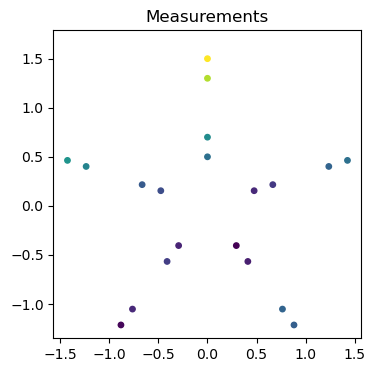

In [5]:
# Plot delle misure dei sensori
plt.figure(figsize=(4,4))
plt.scatter(*xy_measurement.T, c=u_measured, s=15)
plt.axis("square")
plt.title("Measurements")
None


In [6]:
# Domain data
n_col_sqrt = 1

x_col = np.linspace(*x_span, num=n_col_sqrt)
y_col = np.linspace(*x_span, num=n_col_sqrt)
xy_col = np.stack(np.meshgrid(x_col, y_col), axis=-1)
xy_col = xy_col.reshape(-1, n_dim)

In [7]:
# from pyDOE import lhs
# Ncl = 16
# X_coll = lhs(2,Ncl)
# X_coll = -2.0 + X_coll * 4.0
# xy_col = X_coll.reshape(-1, n_dim)

Define networks to model u and gamma

In [7]:
n_basis = 800
u_seed = 99

def get_model(points, target, n_basis, seed):
    domain = Domain(interior_points=points)
    ansatz = BasicAnsatz(n_basis=n_basis,
                         activation="tanh",
                         random_seed=seed)
    ansatz.fit(domain, target)
    linear = Linear(regularization_scale=1e-12)
    if target is not None:
        weights = np.linalg.lstsq(
            ansatz.transform(points), target, rcond=1e-12
            )[0]
        linear.weights = weights
    linear.biases = np.zeros((1, 1))
    linear.layer_width = 1
    return ansatz, linear

u_ansatz, u_linear = get_model(xy_measurement, u_measured, n_basis, u_seed)

In [8]:
def forcing(v):
    return np.ones((v.shape[0],1))

Run the alternating least squares to solve the bilinear problem

In [9]:
n_iters = 1

forcing_col = forcing(xy_col)
training_start = time()
for _ in range(n_iters):
    u_phi_measured = u_ansatz.transform(xy_measurement)
    # u_phi = u_ansatz.transform(xy_col)
    # u_approx = u_linear.transform(u_phi)
    u_phi_x = u_ansatz.transform(xy_col, operator="gradient")


    # Least squares for computing u_approx: use updated value of gamma
    # and also stack the true values we know at the measurement points
    matrix_in_u = Cv * np.sqrt(np.einsum("nkd,df,nkf->nk", u_phi_x, D, u_phi_x))
    
    matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])
    matrix_out_u = np.concatenate([forcing_col, u_measured])

    u_outer_weights = np.linalg.lstsq(
        matrix_in_u, matrix_out_u, rcond=1e-12
    )[0]

u_linear.weights = u_outer_weights

training_time = time() - training_start
print(f"Training time: {training_time}")

Training time: 0.035334110260009766


/tmp/ipykernel_61286/2668710257.py:16: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])


Evaluate the predictions

In [10]:
u_model = Pipeline([("ansatz", u_ansatz), ("linear", u_linear)])
u_pred = u_model.transform(xy_test).ravel()

In [11]:
from Eikonal_groundtruth import *
u_true = anysotropic_FMM_fast(x0, y0, t0, x1, y1, t1, Cv, r)

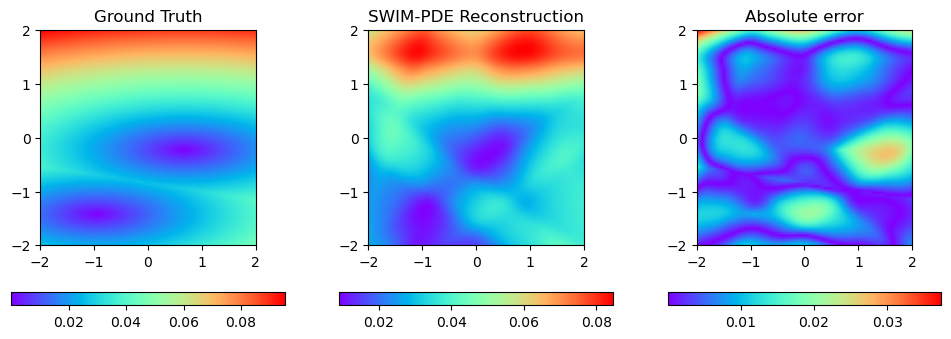

In [12]:
# Visualize predictions of u
data = {"Ground Truth": u_true,
        "SWIM-PDE Reconstruction": u_pred,
        "Absolute error": np.abs(u_true.reshape(-1) - u_pred.ravel())}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap = "rainbow")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")

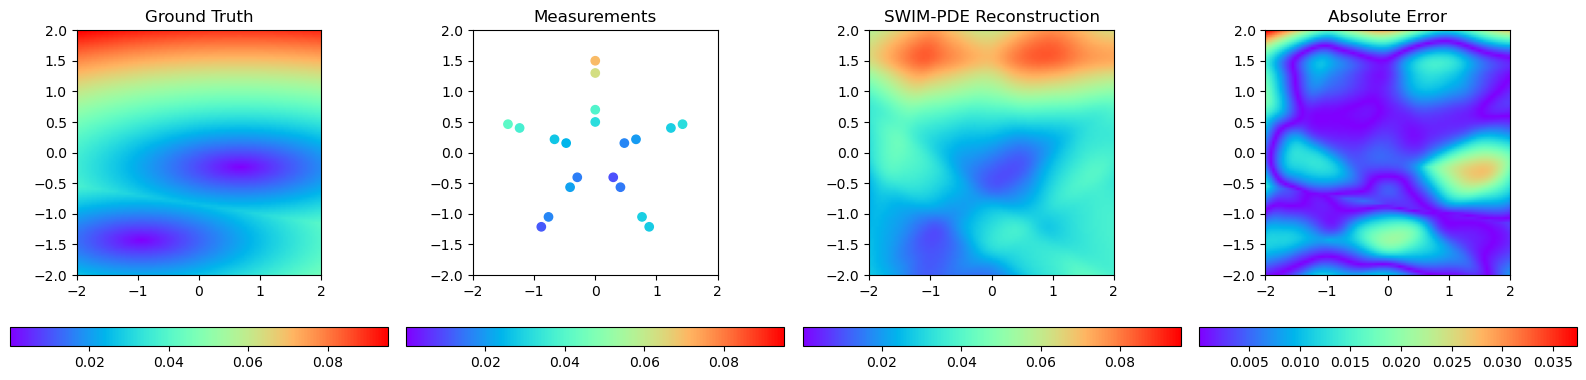

In [14]:
vmin = np.min(u_true)
vmax = np.max(u_true)

data = {
    "Ground Truth": u_true,
    "SWIM-PDE Reconstruction": u_pred,
    "Absolute error": np.abs(u_true.reshape(-1) - u_pred),
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot 1 - Ground Truth
squared = data["Ground Truth"].reshape(101, 101)
im0 = axes[0].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow", vmin=vmin, vmax=vmax)
axes[0].set_title("Ground Truth")
fig.colorbar(im0, ax=axes[0], orientation="horizontal")

# Plot 2 - Measurements (scatterplot)
scatter = axes[1].scatter(xy_measurement[:, 0], xy_measurement[:, 1], c=u_measured, cmap="rainbow", vmin=vmin, vmax=vmax)
axes[1].set_title("Measurements")
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect("equal")
fig.colorbar(scatter, ax=axes[1], orientation="horizontal")

# Plot 3 - PINN Reconstruction
squared = data["SWIM-PDE Reconstruction"].reshape(101, 101)
im2 = axes[2].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow", vmin=vmin, vmax=vmax)
axes[2].set_title("SWIM-PDE Reconstruction")
fig.colorbar(im2, ax=axes[2], orientation="horizontal")

# Plot 4 - Absolute Error (con scala diversa)
squared = data["Absolute error"].reshape(101, 101)
im3 = axes[3].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow")
axes[3].set_title("Absolute Error")
fig.colorbar(im3, ax=axes[3], orientation="horizontal")

plt.tight_layout()
plt.show()
